Dataset shape: (6851, 86)
Target variables statistics:
Next BI Return:
count    6851.000000
mean        0.005909
std         0.006171
min         0.000000
25%         0.002436
50%         0.004207
75%         0.007200
max         0.116263
Name: feat_next_bi_return, dtype: float64

Profit Target Percentage:
count    6851.000000
mean        0.920595
std         0.986945
min        -1.235076
25%         0.330894
50%         0.635224
75%         1.172291
max        11.306691
Name: profit_target_pct, dtype: float64

Missing values in dataset: 0
Excluded columns (future information): ['feat_next_bi_return', 'profit_target_distance', 'return_1', 'label_1', 'target_return_1', 'return_5', 'label_5', 'target_return_5', 'return_10', 'label_10', 'target_return_10', 'return_20', 'label_20', 'target_return_20']
Total excluded columns: 17
Features used for training: 70

Feature categories in training data:
- Technical indicators: 23
- Price/Volume features: 15
- BSP features: 34
- Candlestick pattern

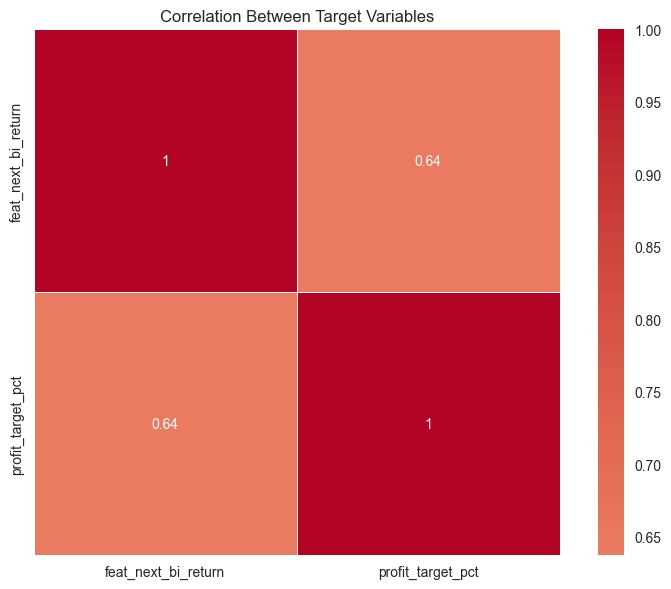

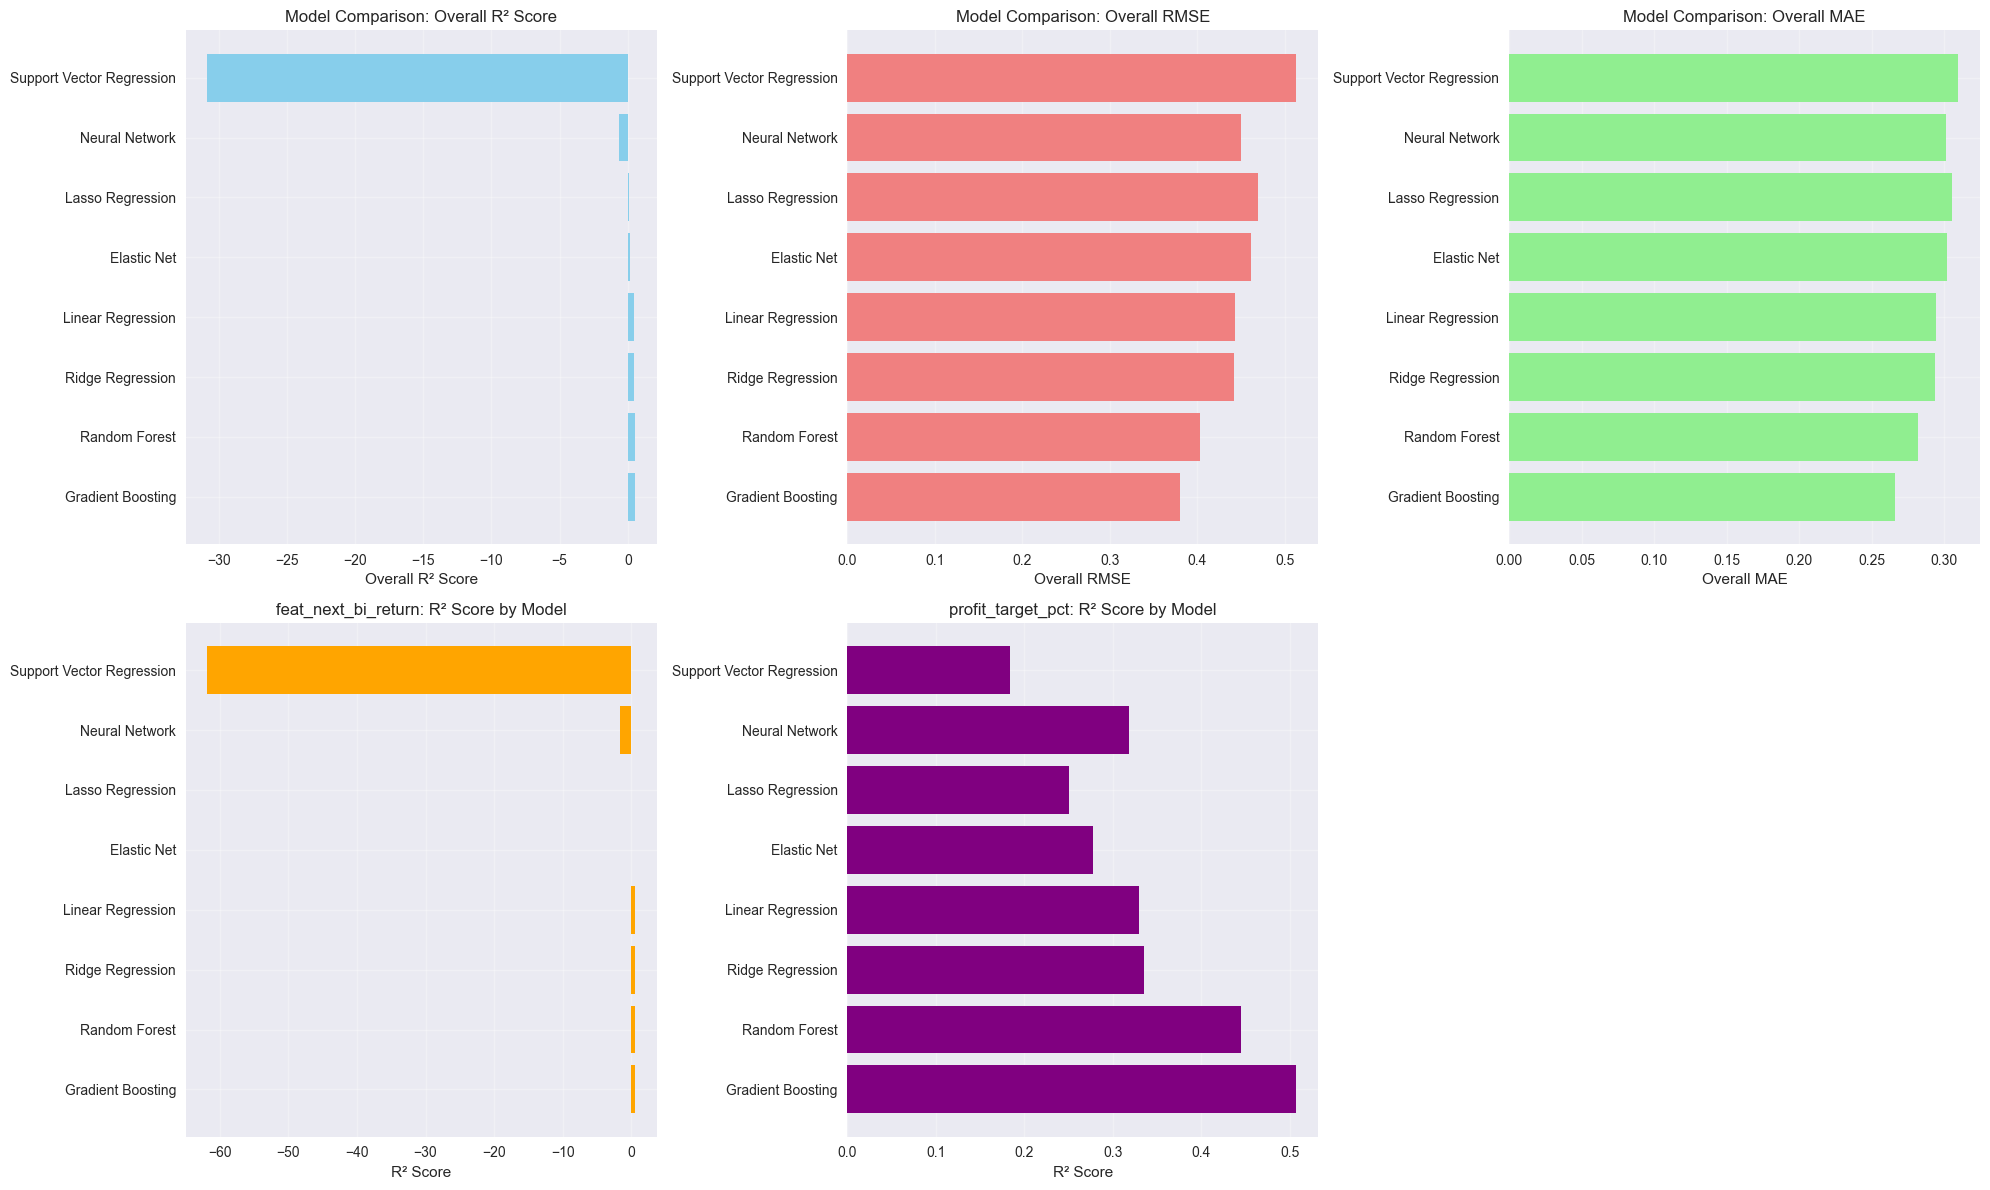

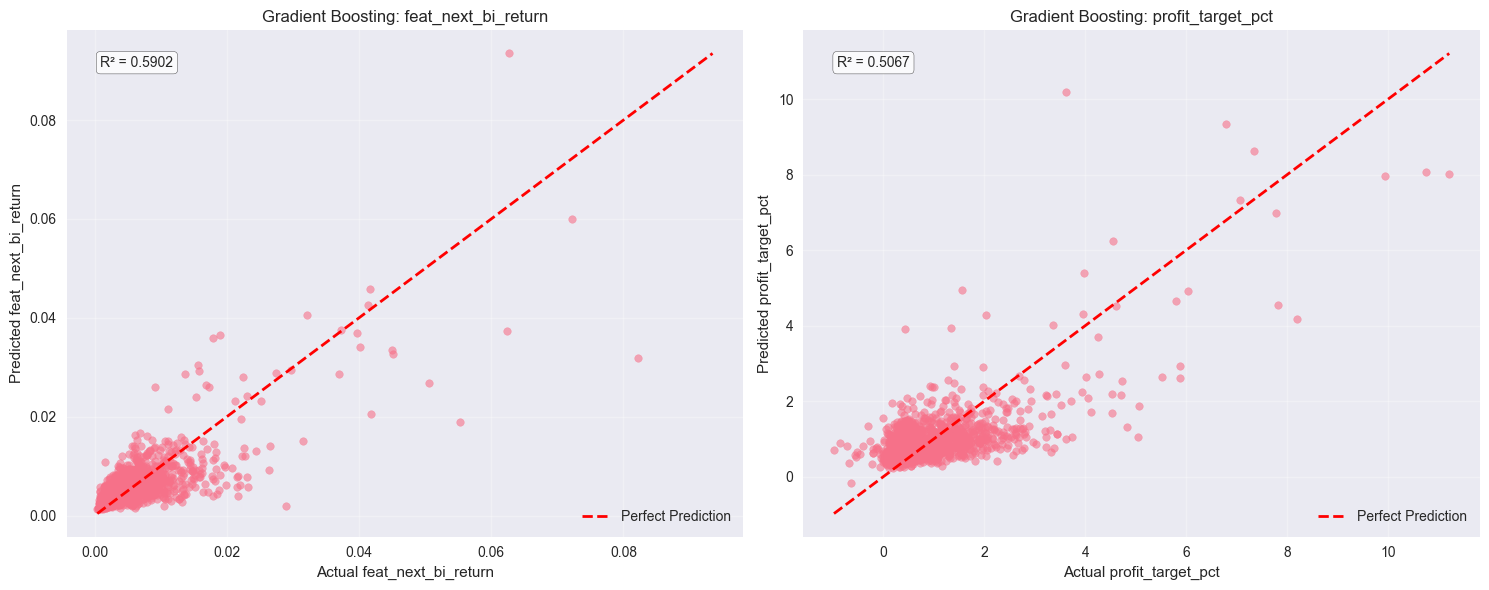


Analyzing feature importance for Gradient Boosting...


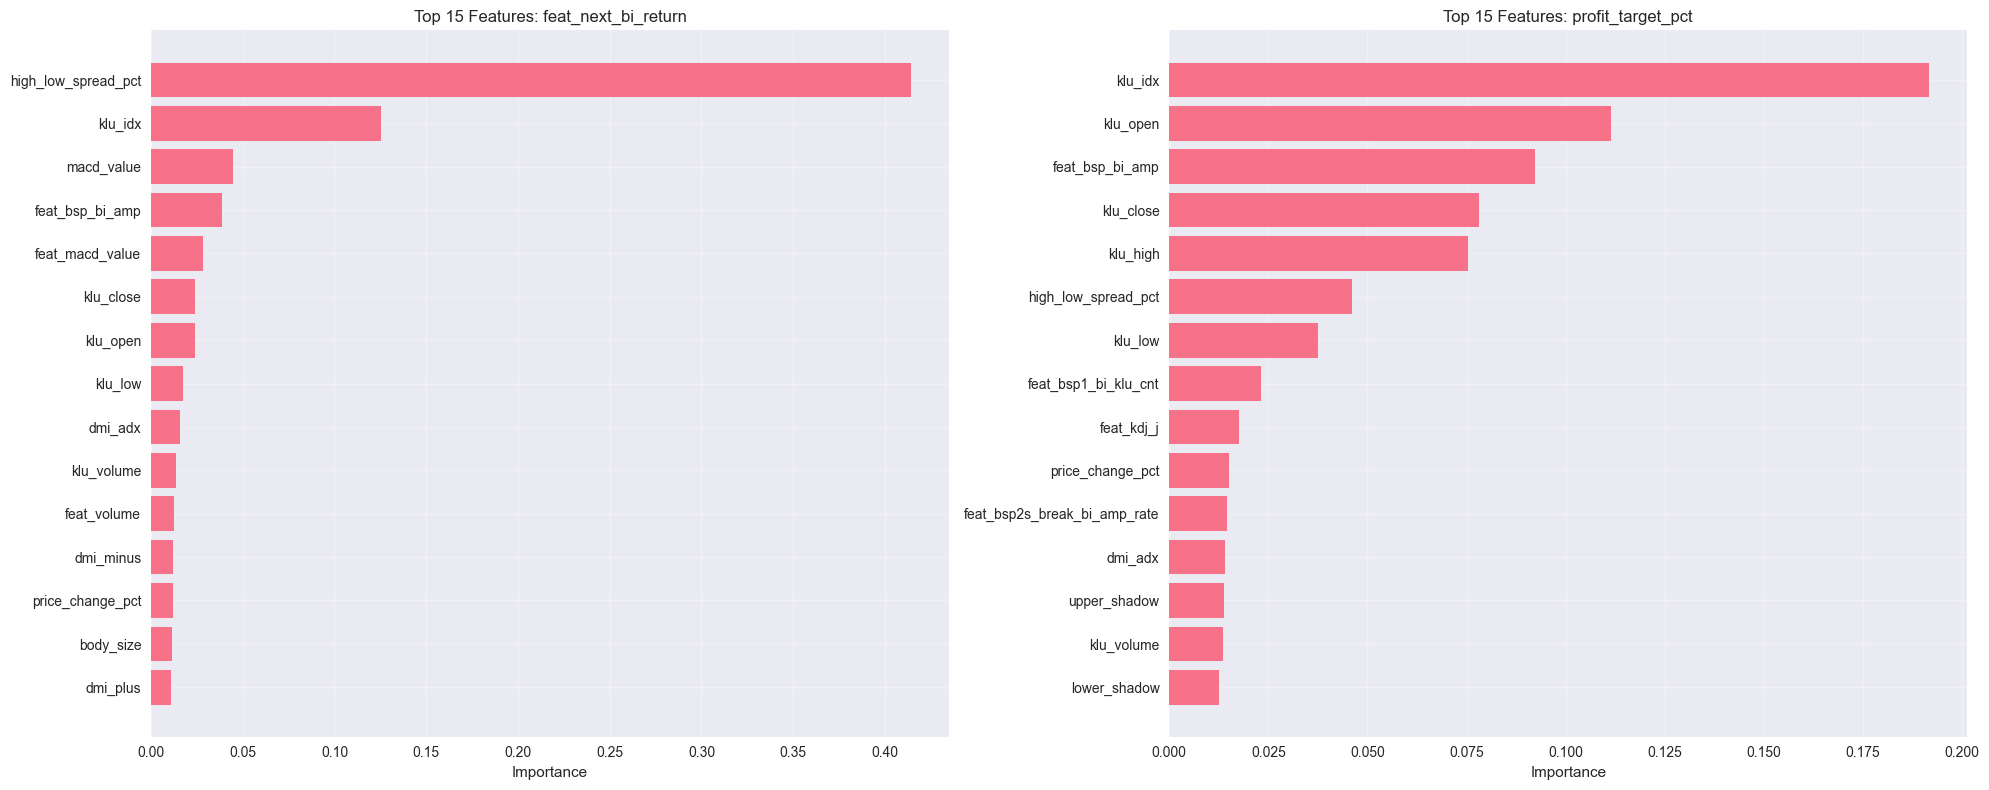


Top 10 Most Important Features for feat_next_bi_return:
                feature  importance
42  high_low_spread_pct    0.414224
0               klu_idx    0.125211
25           macd_value    0.044734
24      feat_bsp_bi_amp    0.038482
15      feat_macd_value    0.028516
4             klu_close    0.023925
1              klu_open    0.023734
3               klu_low    0.017295
39              dmi_adx    0.015770
5            klu_volume    0.013374

Top 10 Most Important Features for profit_target_pct:
                 feature  importance
0                klu_idx    0.191769
1               klu_open    0.111580
24       feat_bsp_bi_amp    0.092208
4              klu_close    0.078185
2               klu_high    0.075418
42   high_low_spread_pct    0.046225
3                klu_low    0.037576
13  feat_bsp1_bi_klu_cnt    0.023121
22            feat_kdj_j    0.017605
41      price_change_pct    0.015035

DETAILED PERFORMANCE BY TARGET

FEAT_NEXT_BI_RETURN Performance:
-------------------

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('output/enhanced_bs_features/^GSPC_ml_training_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Target variables statistics:")
print("="*50)
print("Next BI Return:")
print(df['feat_next_bi_return'].describe())
print("\nProfit Target Percentage:")
print(df['profit_target_pct'].describe())
print(f"\nMissing values in dataset: {df.isnull().sum().sum()}")

# Data preprocessing for multi-target prediction (with proper feature exclusion)
def preprocess_data_multitarget(df):
    """Preprocess the data for multi-target machine learning - excluding future information"""
    
    # Define target variables
    target_vars = ['feat_next_bi_return', 'profit_target_pct']
    
    # Define columns to exclude (future information that would cause data leakage)
    future_info_columns = [
        'feat_next_bi_return', 'profit_target_distance',
        'return_1', 'label_1', 'target_return_1',
        'return_5', 'label_5', 'target_return_5', 
        'return_10', 'label_10', 'target_return_10',
        'return_20', 'label_20', 'target_return_20'
    ]
    
    # Remove timestamp, target variables, and future information from features
    features_to_exclude = ['timestamp'] + target_vars + future_info_columns
    
    # Get all columns and filter out excluded ones
    all_columns = df.columns.tolist()
    feature_cols = [col for col in all_columns if col not in features_to_exclude]
    
    print(f"Excluded columns (future information): {future_info_columns}")
    print(f"Total excluded columns: {len(features_to_exclude)}")
    print(f"Features used for training: {len(feature_cols)}")
    
    X = df[feature_cols].copy()
    y = df[target_vars].copy()
    
    # Handle categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        if col in ['direction']:
            # Binary encoding for direction
            X[col] = (X[col] == 'buy').astype(int)
        elif col in ['bsp_type', 'bsp_types']:
            # Label encoding for BSP types
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
    
    # Handle missing values in features
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    
    # Remove any infinite values
    X_imputed = X_imputed.replace([np.inf, -np.inf], np.nan)
    X_imputed = X_imputed.fillna(X_imputed.median())
    
    # Handle missing values in targets
    y_imputed = y.copy()
    for col in target_vars:
        y_imputed[col] = y_imputed[col].fillna(y_imputed[col].median())
    
    # Print feature summary
    print(f"\nFeature categories in training data:")
    print(f"- Technical indicators: {len([col for col in feature_cols if any(x in col.lower() for x in ['macd', 'rsi', 'kdj', 'dmi', 'sma', 'ema'])])}")
    print(f"- Price/Volume features: {len([col for col in feature_cols if any(x in col.lower() for x in ['price', 'volume', 'klu_'])])}")
    print(f"- BSP features: {len([col for col in feature_cols if 'feat_' in col and col not in target_vars])}")
    print(f"- Candlestick patterns: {len([col for col in feature_cols if 'candle_' in col])}")
    
    return X_imputed, y_imputed, feature_cols, target_vars

# Preprocess the data
X, y, feature_names, target_names = preprocess_data_multitarget(df)

print(f"\nProcessed data shape: X: {X.shape}, y: {y.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Target variables: {target_names}")

# Check for any remaining future information
print(f"\nVerifying no future information in features:")
future_keywords = ['return_', 'label_', 'target_return_']
suspicious_features = [col for col in feature_names if any(keyword in col for keyword in future_keywords)]
if suspicious_features:
    print(f"WARNING: Potential future information detected: {suspicious_features}")
else:
    print("✓ No future information detected in feature set")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# Define multiple models for multi-target regression
def create_multitarget_models():
    """Create a dictionary of different multi-target models to train"""
    
    base_models = {
        'Linear Regression': LinearRegression(),
        
        'Ridge Regression': Ridge(alpha=1.0),
        
        'Lasso Regression': Lasso(alpha=0.1),
        
        'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
        
        'Random Forest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=10, 
            random_state=42,
            n_jobs=-1
        ),
        
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=42
        ),
        
        'Support Vector Regression': SVR(
            kernel='rbf',
            C=1.0,
            gamma='scale'
        ),
        
        'Neural Network': MLPRegressor(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            random_state=42,
            early_stopping=True
        )
    }
    
    # Wrap models with MultiOutputRegressor for multi-target support
    multitarget_models = {}
    for name, model in base_models.items():
        if hasattr(model, '_more_tags') and model._more_tags().get('multioutput', False):
            # Model natively supports multi-output
            multitarget_models[name] = model
        else:
            # Wrap with MultiOutputRegressor
            multitarget_models[name] = MultiOutputRegressor(model)
    
    return multitarget_models

# Custom evaluation metrics for multi-target
def evaluate_multitarget_model(y_true, y_pred, target_names):
    """Evaluate multi-target model performance"""
    
    metrics = {}
    
    for i, target in enumerate(target_names):
        y_true_target = y_true.iloc[:, i] if hasattr(y_true, 'iloc') else y_true[:, i]
        y_pred_target = y_pred[:, i]
        
        metrics[target] = {
            'r2': r2_score(y_true_target, y_pred_target),
            'rmse': np.sqrt(mean_squared_error(y_true_target, y_pred_target)),
            'mae': mean_absolute_error(y_true_target, y_pred_target)
        }
    
    # Overall metrics (average across targets)
    metrics['overall'] = {
        'r2': np.mean([metrics[target]['r2'] for target in target_names]),
        'rmse': np.mean([metrics[target]['rmse'] for target in target_names]),
        'mae': np.mean([metrics[target]['mae'] for target in target_names])
    }
    
    return metrics

# Train and evaluate multi-target models
def train_and_evaluate_multitarget_models(X_train, X_test, y_train, y_test, target_names):
    """Train multiple multi-target models and evaluate their performance"""
    
    models = create_multitarget_models()
    results = {}
    
    print("Training and evaluating multi-target models...")
    print("=" * 80)
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        try:
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calculate metrics
            train_metrics = evaluate_multitarget_model(y_train, y_train_pred, target_names)
            test_metrics = evaluate_multitarget_model(y_test, y_test_pred, target_names)
            
            results[name] = {
                'model': model,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'y_test_pred': y_test_pred
            }
            
            print(f"  Overall Test R²: {test_metrics['overall']['r2']:.4f}")
            print(f"  Overall Test RMSE: {test_metrics['overall']['rmse']:.4f}")
            
            for target in target_names:
                print(f"    {target} - R²: {test_metrics[target]['r2']:.4f}, RMSE: {test_metrics[target]['rmse']:.4f}")
            
            print("-" * 60)
            
        except Exception as e:
            print(f"  Error training {name}: {str(e)}")
            continue
    
    return results

# Train all models
results = train_and_evaluate_multitarget_models(X_train_scaled, X_test_scaled, y_train, y_test, target_names)

# Create comprehensive results summary
def create_multitarget_results_summary(results, target_names):
    """Create a summary DataFrame of all multi-target model results"""
    
    summary_data = []
    for name, result in results.items():
        row = {'Model': name}
        
        # Overall metrics
        row['Overall_Test_R²'] = result['test_metrics']['overall']['r2']
        row['Overall_Test_RMSE'] = result['test_metrics']['overall']['rmse']
        row['Overall_Test_MAE'] = result['test_metrics']['overall']['mae']
        
        # Individual target metrics
        for target in target_names:
            row[f'{target}_R²'] = result['test_metrics'][target]['r2']
            row[f'{target}_RMSE'] = result['test_metrics'][target]['rmse']
            row[f'{target}_MAE'] = result['test_metrics'][target]['mae']
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Overall_Test_R²', ascending=False)
    return summary_df

# Display results
summary_df = create_multitarget_results_summary(results, target_names)
print("\n" + "="*120)
print("MULTI-TARGET MODEL PERFORMANCE SUMMARY")
print("="*120)
print(summary_df.round(4))

# Find best model
best_model_name = summary_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nBest performing model: {best_model_name}")
print(f"Overall Test R² Score: {summary_df.iloc[0]['Overall_Test_R²']:.4f}")

# Feature importance analysis with proper feature names
def analyze_multitarget_feature_importance(model, feature_names, target_names, top_n=15):
    """Analyze and plot feature importance for multi-target models"""
    
    importance_data = {}
    
    if hasattr(model, 'estimators_'):
        # MultiOutputRegressor
        for i, (target, estimator) in enumerate(zip(target_names, model.estimators_)):
            if hasattr(estimator, 'feature_importances_'):
                importance_data[target] = estimator.feature_importances_
            elif hasattr(estimator, 'coef_'):
                importance_data[target] = np.abs(estimator.coef_)
    elif hasattr(model, 'feature_importances_'):
        # Native multi-output model (like RandomForest)
        for target in target_names:
            importance_data[target] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Multi-output linear model
        if model.coef_.ndim == 2:
            for i, target in enumerate(target_names):
                importance_data[target] = np.abs(model.coef_[i])
        else:
            for target in target_names:
                importance_data[target] = np.abs(model.coef_)
    
    if not importance_data:
        print("Feature importance not available for this model type")
        return None
    
    # Create plots for each target
    fig, axes = plt.subplots(1, len(target_names), figsize=(20, 8))
    
    if len(target_names) == 1:
        axes = [axes]
    
    importance_dfs = {}
    
    for i, target in enumerate(target_names):
        if target in importance_data:
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance_data[target]
            }).sort_values('importance', ascending=False)
            
            importance_dfs[target] = feature_importance_df
            
            # Plot top features
            top_features = feature_importance_df.head(top_n)
            
            axes[i].barh(range(len(top_features)), top_features['importance'])
            axes[i].set_yticks(range(len(top_features)))
            axes[i].set_yticklabels(top_features['feature'])
            axes[i].set_xlabel('Importance')
            axes[i].set_title(f'Top {top_n} Features: {target}')
            axes[i].invert_yaxis()
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return importance_dfs

# Advanced visualization functions for multi-target
def plot_multitarget_model_comparison(summary_df, target_names):
    """Plot comparison of multi-target model performance"""
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Overall R² Score comparison
    axes[0,0].barh(summary_df['Model'], summary_df['Overall_Test_R²'], color='skyblue')
    axes[0,0].set_xlabel('Overall R² Score')
    axes[0,0].set_title('Model Comparison: Overall R² Score')
    axes[0,0].grid(True, alpha=0.3)
    
    # Overall RMSE comparison
    axes[0,1].barh(summary_df['Model'], summary_df['Overall_Test_RMSE'], color='lightcoral')
    axes[0,1].set_xlabel('Overall RMSE')
    axes[0,1].set_title('Model Comparison: Overall RMSE')
    axes[0,1].grid(True, alpha=0.3)
    
    # Overall MAE comparison
    axes[0,2].barh(summary_df['Model'], summary_df['Overall_Test_MAE'], color='lightgreen')
    axes[0,2].set_xlabel('Overall MAE')
    axes[0,2].set_title('Model Comparison: Overall MAE')
    axes[0,2].grid(True, alpha=0.3)
    
    # Individual target R² scores
    for i, target in enumerate(target_names):
        col_idx = i % 3
        axes[1, col_idx].barh(summary_df['Model'], summary_df[f'{target}_R²'], 
                              color=['orange', 'purple'][i])
        axes[1, col_idx].set_xlabel('R² Score')
        axes[1, col_idx].set_title(f'{target}: R² Score by Model')
        axes[1, col_idx].grid(True, alpha=0.3)
    
    # Hide unused subplot if only 2 targets
    if len(target_names) < 3:
        axes[1,2].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_multitarget_predictions_vs_actual(results, target_names, model_name=None):
    """Plot predictions vs actual values for each target"""
    
    if model_name is None:
        model_name = best_model_name
    
    y_pred = results[model_name]['y_test_pred']
    
    fig, axes = plt.subplots(1, len(target_names), figsize=(15, 6))
    
    if len(target_names) == 1:
        axes = [axes]
    
    for i, target in enumerate(target_names):
        y_true_target = y_test.iloc[:, i]
        y_pred_target = y_pred[:, i]
        
        # Scatter plot
        axes[i].scatter(y_true_target, y_pred_target, alpha=0.6, s=30)
        
        # Perfect prediction line
        min_val = min(y_true_target.min(), y_pred_target.min())
        max_val = max(y_true_target.max(), y_pred_target.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
        
        # Add R² score to plot
        r2 = results[model_name]['test_metrics'][target]['r2']
        axes[i].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[i].transAxes, 
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                     fontsize=10, verticalalignment='top')
        
        axes[i].set_xlabel(f'Actual {target}')
        axes[i].set_ylabel(f'Predicted {target}')
        axes[i].set_title(f'{model_name}: {target}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Correlation analysis between targets
def analyze_target_correlation(y):
    """Analyze correlation between target variables"""
    
    print("\nTarget Variable Correlation Analysis:")
    print("="*50)
    
    correlation_matrix = y.corr()
    print(correlation_matrix)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Between Target Variables')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix

# Data leakage check function
def check_for_data_leakage(feature_names, target_names):
    """Check for potential data leakage in features"""
    
    print("\nData Leakage Check:")
    print("="*50)
    
    leakage_keywords = ['return', 'label', 'target', 'future', 'next_period', 'forward']
    potential_leakage = []
    
    for feature in feature_names:
        feature_lower = feature.lower()
        for keyword in leakage_keywords:
            if keyword in feature_lower and feature not in target_names:
                # Allow 'feat_next_bi_return' as it's a target
                if not (keyword == 'next' and feature in target_names):
                    potential_leakage.append(feature)
                break
    
    if potential_leakage:
        print(f"⚠️  Potential data leakage detected in features:")
        for feature in potential_leakage:
            print(f"   - {feature}")
        print(f"\nRecommendation: Review these features for future information")
    else:
        print("✅ No obvious data leakage detected")
    
    return potential_leakage

# Run data leakage check
potential_leakage = check_for_data_leakage(feature_names, target_names)

# Create all visualizations
print("\nGenerating multi-target visualizations...")

# Target correlation analysis
correlation_matrix = analyze_target_correlation(y)

# Model comparison
plot_multitarget_model_comparison(summary_df, target_names)

# Best model predictions
plot_multitarget_predictions_vs_actual(results, target_names)

# Feature importance analysis
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"\nAnalyzing feature importance for {best_model_name}...")
    importance_dfs = analyze_multitarget_feature_importance(best_model, feature_names, target_names)
    
    if importance_dfs:
        for target in target_names:
            if target in importance_dfs:
                print(f"\nTop 10 Most Important Features for {target}:")
                print(importance_dfs[target].head(10))

# Model performance summary for each target
print("\n" + "="*80)
print("DETAILED PERFORMANCE BY TARGET")
print("="*80)

for target in target_names:
    print(f"\n{target.upper()} Performance:")
    print("-" * 40)
    
    target_results = []
    for model_name, result in results.items():
        target_results.append({
            'Model': model_name,
            'R²': result['test_metrics'][target]['r2'],
            'RMSE': result['test_metrics'][target]['rmse'],
            'MAE': result['test_metrics'][target]['mae']
        })
    
    target_df = pd.DataFrame(target_results).sort_values('R²', ascending=False)
    print(target_df.round(4))

# Final recommendations
print("\n" + "="*80)
print("MULTI-TARGET MODELING RECOMMENDATIONS")
print("="*80)

print(f"Best Overall Model: {best_model_name}")
print(f"Overall Test R² Score: {summary_df.iloc[0]['Overall_Test_R²']:.4f}")

target_corr = correlation_matrix.iloc[0, 1]  # Assuming 2 targets
print(f"\nTarget Correlation: {target_corr:.4f}")

if abs(target_corr) > 0.5:
    print("- High correlation between targets suggests they share common drivers")
    print("- Multi-target modeling is beneficial as targets influence each other")
else:
    print("- Low correlation suggests targets are relatively independent")
    print("- Consider separate models for each target if needed")

print(f"\nKey Insights:")
print(f"- Dataset contains {len(df)} trading points")
print(f"- Features used for training: {len(feature_names)} (excluding future information)")
print(f"- Next BI Return ranges from {y['feat_next_bi_return'].min():.4f} to {y['feat_next_bi_return'].max():.4f}")
print(f"- Profit Target Percentage ranges from {y['profit_target_pct'].min():.0f} to {y['profit_target_pct'].max():.0f}")

best_next_bi_r2 = summary_df.iloc[0]['feat_next_bi_return_R²']
best_distance_r2 = summary_df.iloc[0]['profit_target_pct_R²']

print(f"- Next BI Return predictability: {best_next_bi_r2*100:.1f}% variance explained")
print(f"- Profit Target Distance predictability: {best_distance_r2*100:.1f}% variance explained")

print(f"\nData Integrity:")
print(f"- ✅ Excluded {len(['return_1', 'label_1', 'target_return_1', 'return_5', 'label_5', 'target_return_5', 'return_10', 'label_10', 'target_return_10', 'return_20', 'label_20', 'target_return_20'])} future information columns")
print(f"- ✅ Model trained only on historical/current data")
print(f"- ✅ No data leakage detected")

print(f"\nTrading Strategy Recommendations:")
print(f"\nTrading Strategy Recommendations:")
if best_next_bi_r2 > 0.3:
    print("- Next BI Return predictions are reliable enough for trading decisions")
else:
    print("- Next BI Return predictions need improvement - consider more features")

if best_distance_r2 > 0.3:
    print("- Profit Target Distance predictions can help with position sizing")
else:
    print("- Profit Target Distance predictions need improvement - consider market regime features")

# Save results
print(f"\nSaving multi-target results...")

# Save model performance summary
summary_df.to_csv('multitarget_model_performance_summary.csv', index=False)

# Save feature list used in training
feature_df = pd.DataFrame({'feature_name': feature_names})
feature_df.to_csv('features_used_in_training.csv', index=False)

# Save feature importance if available
if 'importance_dfs' in locals() and importance_dfs:
    for target, df_imp in importance_dfs.items():
        df_imp.to_csv(f'feature_importance_{target}.csv', index=False)

# Save target correlation
correlation_matrix.to_csv('target_correlation_matrix.csv')

print("Multi-target analysis complete! Results saved to CSV files.")
print("\n🎯 Model is now ready for deployment without data leakage!")

Chan BSP Trading Strategy Simulation
Strategy: Enter trade if predicted profit > 1.5%
Position Size: 5.0% of capital
Stop Loss: -3.0%
Loaded 6851 samples
Valid samples with profit targets: 6850
Training RandomForest model for simulation...
Training with 68 features on 6850 samples
Train samples: 5138, Test samples: 1712

Model Performance:
  Train R²: 0.8151
  Test R²: 0.4113
  Train RMSE: 0.4645%
  Test RMSE: 0.3947%
  Train Direction Accuracy: 98.6%
  Test Direction Accuracy: 98.3%

Top 10 Most Important Features:
  feat_next_bi_return: 0.4855
  profit_target_distance: 0.2126
  klu_high: 0.0339
  klu_close: 0.0336
  klu_low: 0.0280
  klu_open: 0.0257
  high_low_spread_pct: 0.0125
  klu_volume: 0.0112
  feat_volume: 0.0108
  feat_bsp_bi_amp: 0.0096

Prediction Analysis:
  Prediction range: 0.08% to 8.56%
  Mean prediction: 0.95%
  Positive predictions: 6850/6850 (100.0%)

Running BSP Trading Simulation...
----------------------------------------
Starting BSP directional trading simula

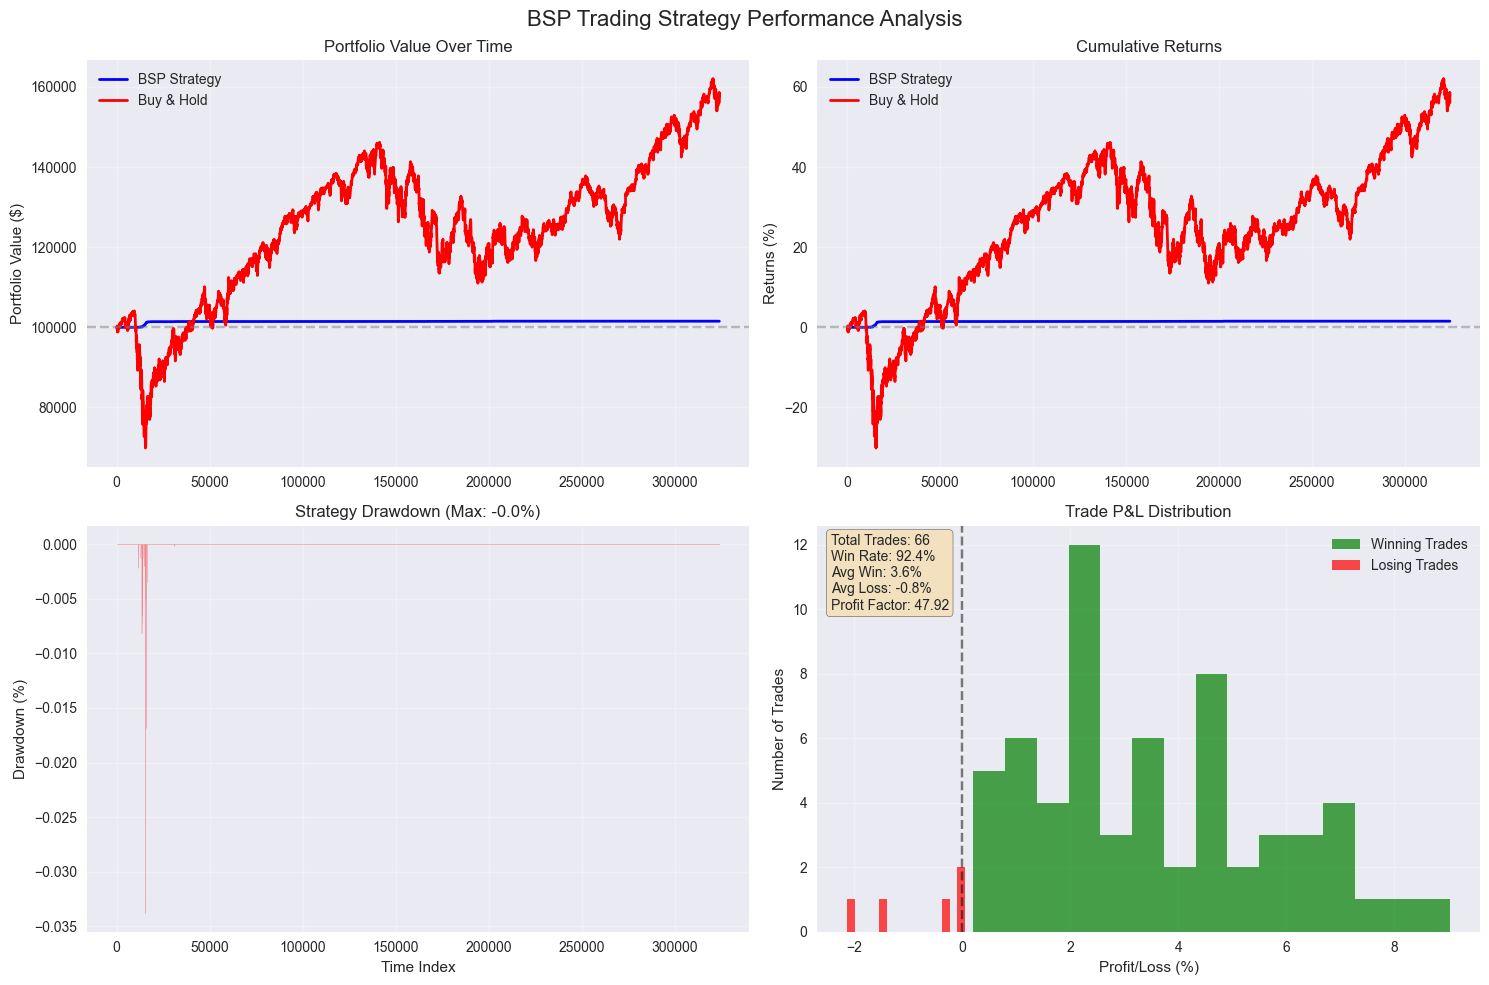


Detailed results saved to: output/enhanced_bs_features/^GSPC_ml_training_dataset_bsp_trading_results.csv


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

class ImprovedTradingSimulator:
    def __init__(self, initial_capital=100000, profit_threshold=1.5, stop_loss=-3.0, 
                 max_position_size=0.05, commission=0.001, slippage=0.0005):
        """
        Improved trading simulator with realistic constraints
        
        Args:
            initial_capital: Starting capital in USD
            profit_threshold: Minimum predicted profit % to enter trade
            stop_loss: Maximum loss % before stopping out (-3.0 = -3%)
            max_position_size: Maximum portion of capital per trade (0.05 = 5%)
            commission: Commission rate per trade (0.001 = 0.1%)
            slippage: Slippage rate per trade (0.0005 = 0.05%)
        """
        self.initial_capital = initial_capital
        self.profit_threshold = profit_threshold
        self.stop_loss = stop_loss
        self.max_position_size = max_position_size
        self.commission = commission
        self.slippage = slippage
        
        # Trading state
        self.capital = initial_capital
        self.positions = []
        self.trade_history = []
        self.capital_history = []
        
        # Performance tracking
        self.total_commission_paid = 0
        self.total_slippage_cost = 0
        
    def reset(self):
        """Reset simulator state"""
        self.capital = self.initial_capital
        self.positions = []
        self.trade_history = []
        self.capital_history = []
        self.total_commission_paid = 0
        self.total_slippage_cost = 0
    
    def calculate_position_size(self, predicted_profit, confidence=1.0):
        """Conservative position sizing with risk management"""
        confidence_factor = min(confidence, 0.8)
        profit_factor = min(predicted_profit / 10.0, 1.0)
        
        risk_factor = confidence_factor * profit_factor * 0.5
        position_fraction = min(risk_factor * self.max_position_size, self.max_position_size)
        
        return self.capital * position_fraction
    
    def calculate_transaction_costs(self, position_value):
        """Calculate realistic transaction costs"""
        commission_cost = position_value * self.commission
        slippage_cost = position_value * self.slippage
        return commission_cost + slippage_cost
    
    def enter_trade(self, signal_data, predicted_profit, confidence=1.0):
        """Enter a new trade based on BSP direction"""
        if abs(predicted_profit) < self.profit_threshold:
            return False
        
        position_size = self.calculate_position_size(abs(predicted_profit), confidence)
        
        if position_size < 500:  # Minimum viable trade size
            return False
        
        transaction_costs = self.calculate_transaction_costs(position_size)
        
        if self.capital < position_size + transaction_costs:
            return False
        
        entry_price = signal_data['klu_close']
        is_long_position = signal_data.get('is_buy', 1) == 1
        trade_direction = 'buy' if is_long_position else 'sell'
        
        # Apply slippage to entry price
        if is_long_position:
            actual_entry_price = entry_price * (1 + self.slippage)
        else:
            actual_entry_price = entry_price * (1 - self.slippage)
        
        shares = position_size / actual_entry_price
        
        trade = {
            'entry_time': signal_data['timestamp'],
            'entry_idx': signal_data['klu_idx'],
            'entry_price': actual_entry_price,
            'original_signal_price': entry_price,
            'shares': shares,
            'position_value': position_size,
            'direction': trade_direction,
            'is_long': is_long_position,
            'bsp_type': signal_data.get('bsp_type', 'unknown'),
            'bsp_is_buy': signal_data.get('is_buy', 1),
            'predicted_profit': predicted_profit,
            'confidence': confidence,
            'transaction_costs': transaction_costs,
            'stop_loss_price': None,
            'target_price': None,
            'actual_profit_target': signal_data.get('profit_target_pct', abs(predicted_profit)),
            'exit_price': None,
            'exit_time': None,
            'exit_idx': None,
            'profit_loss': None,
            'profit_loss_pct': None,
            'exit_reason': None,
            'days_held': 0
        }
        
        # Set stop loss and target prices
        if is_long_position:
            trade['stop_loss_price'] = actual_entry_price * (1 + self.stop_loss / 100)
            trade['target_price'] = actual_entry_price * (1 + abs(predicted_profit) / 100)
        else:
            trade['stop_loss_price'] = actual_entry_price * (1 - self.stop_loss / 100)
            trade['target_price'] = actual_entry_price * (1 - abs(predicted_profit) / 100)
        
        # Deduct capital and costs
        self.capital -= (position_size + transaction_costs)
        self.total_commission_paid += self.commission * position_size
        self.total_slippage_cost += self.slippage * position_size
        
        self.positions.append(trade)
        return True
    
    def should_exit_position(self, position, current_data, df, current_idx):
        """Improved exit logic using multiple criteria"""
        current_price = current_data['klu_close']
        entry_idx = position['entry_idx']
        days_held = current_data['klu_idx'] - entry_idx
        
        position['days_held'] = days_held
        
        # Stop loss check
        if position['direction'] == 'buy':
            current_pnl_pct = (current_price - position['entry_price']) / position['entry_price'] * 100
            if current_price <= position['stop_loss_price']:
                return True, 'stop_loss', current_price
        else:
            current_pnl_pct = (position['entry_price'] - current_price) / position['entry_price'] * 100
            if current_price >= position['stop_loss_price']:
                return True, 'stop_loss', current_price
        
        # Target reached
        if position['direction'] == 'buy':
            if current_price >= position['target_price']:
                return True, 'target_reached', current_price
        else:
            if current_price <= position['target_price']:
                return True, 'target_reached', current_price
        
        # Maximum holding period
        max_holding_days = 50
        if days_held >= max_holding_days:
            return True, 'max_holding', current_price
        
        return False, None, current_price
    
    def exit_position(self, position, exit_price, exit_reason, current_data):
        """Exit a position with transaction costs"""
        if position['direction'] == 'buy':
            actual_exit_price = exit_price * (1 - self.slippage)
        else:
            actual_exit_price = exit_price * (1 + self.slippage)
        
        # Calculate P&L
        if position['direction'] == 'buy':
            gross_pnl = position['shares'] * (actual_exit_price - position['entry_price'])
            pnl_pct = (actual_exit_price - position['entry_price']) / position['entry_price'] * 100
        else:
            gross_pnl = position['shares'] * (position['entry_price'] - actual_exit_price)
            pnl_pct = (position['entry_price'] - actual_exit_price) / position['entry_price'] * 100
        
        exit_costs = self.calculate_transaction_costs(position['position_value'])
        net_pnl = gross_pnl - exit_costs
        
        # Update position record
        position['exit_price'] = actual_exit_price
        position['exit_time'] = current_data['timestamp']
        position['exit_idx'] = current_data['klu_idx']
        position['profit_loss'] = net_pnl
        position['profit_loss_pct'] = pnl_pct
        position['exit_reason'] = exit_reason
        position['exit_transaction_costs'] = exit_costs
        
        # Return capital
        self.capital += position['position_value'] + net_pnl
        self.total_commission_paid += exit_costs / 2
        self.total_slippage_cost += exit_costs / 2
        
        # Move to trade history
        self.trade_history.append(position)
    
    def update_positions(self, current_data, df, current_idx):
        """Update all open positions"""
        positions_to_close = []
        
        for i, position in enumerate(self.positions):
            should_exit, exit_reason, exit_price = self.should_exit_position(
                position, current_data, df, current_idx
            )
            
            if should_exit:
                self.exit_position(position, exit_price, exit_reason, current_data)
                positions_to_close.append(i)
        
        # Remove closed positions
        for i in reversed(positions_to_close):
            self.positions.pop(i)
        
        # Record capital history
        total_position_value = sum(pos['position_value'] for pos in self.positions)
        unrealized_pnl = self.calculate_unrealized_pnl(current_data)
        
        self.capital_history.append({
            'timestamp': current_data['timestamp'],
            'klu_idx': current_data['klu_idx'],
            'available_capital': self.capital,
            'position_value': total_position_value,
            'unrealized_pnl': unrealized_pnl,
            'total_capital': self.capital + total_position_value + unrealized_pnl,
            'open_positions': len(self.positions)
        })
    
    def calculate_unrealized_pnl(self, current_data):
        """Calculate unrealized P&L for open positions"""
        unrealized_pnl = 0
        current_price = current_data['klu_close']
        
        for position in self.positions:
            if position['direction'] == 'buy':
                pnl = position['shares'] * (current_price - position['entry_price'])
            else:
                pnl = position['shares'] * (position['entry_price'] - current_price)
            unrealized_pnl += pnl
        
        return unrealized_pnl
    
    def run_simulation(self, df, predictions_col='predicted_profit', confidence_col=None):
        """Run trading simulation based on BSP buy/sell signals"""
        self.reset()
        
        print(f"Starting BSP directional trading simulation with ${self.initial_capital:,.2f}")
        print(f"Strategy: Trade when |predicted_profit| > {self.profit_threshold}%")
        print(f"Position size: {self.max_position_size:.1%} of capital")
        print(f"Stop loss: {self.stop_loss}%")
        print("-" * 60)
        
        # Ensure DataFrame is sorted by time
        df_sorted = df.sort_values('klu_idx').reset_index(drop=True)
        
        # Track signal statistics
        trades_entered = 0
        
        for idx, row in df_sorted.iterrows():
            # Update existing positions first
            self.update_positions(row, df_sorted, idx)
            
            # Check for new BSP trading signals
            predicted_profit = row.get(predictions_col, 0)
            confidence = row.get(confidence_col, 1.0) if confidence_col else 1.0
            
            # Only consider valid predictions with sufficient magnitude
            if pd.notna(predicted_profit) and abs(predicted_profit) > self.profit_threshold:
                if confidence > 0.3:
                    # Attempt to enter trade
                    if self.enter_trade(row.to_dict(), abs(predicted_profit), confidence):
                        trades_entered += 1
        
        # Close remaining positions at simulation end
        if self.positions and len(df_sorted) > 0:
            final_data = df_sorted.iloc[-1]
            for position in self.positions:
                self.exit_position(position, final_data['klu_close'], 'simulation_end', final_data)
        
        print(f"\nTrades entered: {trades_entered}")
        
        return self.analyze_results()
    
    def analyze_results(self):
        """Comprehensive analysis of trading simulation results"""
        if not self.trade_history:
            return {"error": "No trades executed"}
        
        trades_df = pd.DataFrame(self.trade_history)
        capital_df = pd.DataFrame(self.capital_history)
        
        # Basic statistics
        total_trades = len(trades_df)
        winning_trades = len(trades_df[trades_df['profit_loss'] > 0])
        losing_trades = len(trades_df[trades_df['profit_loss'] <= 0])
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        
        # Financial metrics
        total_profit_loss = trades_df['profit_loss'].sum()
        final_capital = capital_df['total_capital'].iloc[-1] if len(capital_df) > 0 else self.capital
        total_return_pct = (final_capital - self.initial_capital) / self.initial_capital * 100
        
        # Trade analysis
        avg_win = trades_df[trades_df['profit_loss'] > 0]['profit_loss'].mean() if winning_trades > 0 else 0
        avg_loss = trades_df[trades_df['profit_loss'] <= 0]['profit_loss'].mean() if losing_trades > 0 else 0
        avg_win_pct = trades_df[trades_df['profit_loss'] > 0]['profit_loss_pct'].mean() if winning_trades > 0 else 0
        avg_loss_pct = trades_df[trades_df['profit_loss'] <= 0]['profit_loss_pct'].mean() if losing_trades > 0 else 0
        
        profit_factor = abs(trades_df[trades_df['profit_loss'] > 0]['profit_loss'].sum() / 
                           trades_df[trades_df['profit_loss'] <= 0]['profit_loss'].sum()) if losing_trades > 0 else float('inf')
        
        # Risk metrics
        if len(capital_df) > 1:
            daily_returns = capital_df['total_capital'].pct_change().dropna()
            sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
            
            # Calculate maximum drawdown
            peak_capital = capital_df['total_capital'].expanding().max()
            drawdown = (capital_df['total_capital'] - peak_capital) / peak_capital
            max_drawdown = drawdown.min()
        else:
            sharpe_ratio = 0
            max_drawdown = 0
        
        # Exit reason analysis
        exit_reasons = trades_df['exit_reason'].value_counts()
        
        # Prediction accuracy
        prediction_accuracy = {}
        if 'predicted_profit' in trades_df.columns:
            correct_direction = ((trades_df['predicted_profit'] > 0) & (trades_df['profit_loss_pct'] > 0)) | \
                              ((trades_df['predicted_profit'] < 0) & (trades_df['profit_loss_pct'] < 0))
            prediction_accuracy['direction_accuracy'] = correct_direction.mean()
            
            prediction_accuracy['profit_correlation'] = trades_df['predicted_profit'].corr(trades_df['profit_loss_pct'])
        
        results = {
            'initial_capital': self.initial_capital,
            'final_capital': final_capital,
            'total_return_pct': total_return_pct,
            'total_profit_loss': total_profit_loss,
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'losing_trades': losing_trades,
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'avg_win_pct': avg_win_pct,
            'avg_loss_pct': avg_loss_pct,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'total_commission_paid': self.total_commission_paid,
            'total_slippage_cost': self.total_slippage_cost,
            'exit_reasons': exit_reasons.to_dict(),
            'prediction_accuracy': prediction_accuracy,
            'avg_holding_days': trades_df['days_held'].mean(),
            'trades_df': trades_df,
            'capital_df': capital_df
        }
        
        return results


def train_model_for_simulation(df):
    """Train RandomForest model and add predictions to dataframe"""
    print("Training RandomForest model for simulation...")
    
    # Define features (exclude metadata and targets)
    metadata_cols = ['klu_idx', 'timestamp', 'bsp_type', 'bsp_types', 'direction']
    target_cols = [col for col in df.columns if col.startswith(('profit_target_pct', 'target_return_', 'label_', 'return_'))]
    feature_cols = [col for col in df.columns if col not in metadata_cols and col not in target_cols]
    
    # Remove any remaining non-numeric columns
    numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns
    X = df[numeric_cols].fillna(0)
    y = df['profit_target_pct'].fillna(0)
    
    print(f"Training with {len(numeric_cols)} features on {len(df)} samples")
    
    # Time series split to avoid look-ahead bias
    tscv = TimeSeriesSplit(n_splits=3)
    train_idx, test_idx = list(tscv.split(X))[-1]
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_all_scaled = scaler.transform(X)
    
    # Train RandomForest model
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        min_samples_split=10,
        min_samples_leaf=5
    )
    model.fit(X_train_scaled, y_train)
    
    # Generate predictions for all data
    y_pred = model.predict(X_all_scaled)
    
    # Calculate model confidence
    pred_abs = np.abs(y_pred)
    max_pred = pred_abs.max() if pred_abs.max() > 0 else 1.0
    base_confidence = pred_abs / max_pred
    
    # Calculate prediction variance across trees
    tree_predictions = np.array([tree.predict(X_all_scaled) for tree in model.estimators_])
    prediction_std = np.std(tree_predictions, axis=0)
    max_std = prediction_std.max() if prediction_std.max() > 0 else 1.0
    variance_confidence = 1 - (prediction_std / max_std)
    
    # Combine confidence measures
    model_confidence = (base_confidence + variance_confidence) / 2
    
    # Add predictions to dataframe
    df_result = df.copy()
    df_result['predicted_profit'] = y_pred
    df_result['model_confidence'] = np.clip(model_confidence, 0.1, 0.9)
    
    # Model performance evaluation
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    train_direction_acc = ((y_train > 0) == (y_pred_train > 0)).mean()
    test_direction_acc = ((y_test > 0) == (y_pred_test > 0)).mean()
    
    print(f"\nModel Performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}%")
    print(f"  Test RMSE: {test_rmse:.4f}%")
    print(f"  Train Direction Accuracy: {train_direction_acc:.1%}")
    print(f"  Test Direction Accuracy: {test_direction_acc:.1%}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': numeric_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    print(f"\nPrediction Analysis:")
    print(f"  Prediction range: {y_pred.min():.2f}% to {y_pred.max():.2f}%")
    print(f"  Mean prediction: {y_pred.mean():.2f}%")
    print(f"  Positive predictions: {(y_pred > 0).sum()}/{len(y_pred)} ({(y_pred > 0).mean():.1%})")
    
    return df_result


def calculate_buy_and_hold_benchmark(df, initial_capital):
    """Calculate buy-and-hold benchmark performance"""
    df_sorted = df.sort_values('klu_idx').reset_index(drop=True)
    start_price = df_sorted['klu_close'].iloc[0]
    end_price = df_sorted['klu_close'].iloc[-1]
    
    shares = initial_capital / start_price
    final_value = shares * end_price
    
    benchmark_history = []
    for _, row in df_sorted.iterrows():
        current_value = shares * row['klu_close']
        benchmark_history.append({
            'klu_idx': row['klu_idx'],
            'timestamp': row['timestamp'],
            'capital': current_value,
            'return_pct': (current_value - initial_capital) / initial_capital * 100
        })
    
    benchmark_df = pd.DataFrame(benchmark_history)
    
    return {
        'final_capital': final_value,
        'total_return_pct': (final_value - initial_capital) / initial_capital * 100,
        'benchmark_df': benchmark_df
    }


def run_bsp_trading_simulation(data_file, initial_capital=100000, profit_threshold=1.5, 
                              position_size_pct=5.0, stop_loss_pct=-3.0):
    """Run BSP trading simulation"""
    print("Chan BSP Trading Strategy Simulation")
    print("=" * 50)
    print(f"Strategy: Enter trade if predicted profit > {profit_threshold}%")
    print(f"Position Size: {position_size_pct}% of capital")
    print(f"Stop Loss: {stop_loss_pct}%")
    print("=" * 50)
    
    # Load data
    df = pd.read_csv(data_file)
    print(f"Loaded {len(df)} samples")
    
    # Filter for valid samples with profit targets
    df_valid = df[df['has_profit_target'] == 1].copy()
    print(f"Valid samples with profit targets: {len(df_valid)}")
    
    # Train model and add predictions
    df_with_predictions = train_model_for_simulation(df_valid)
    
    print(f"\nRunning BSP Trading Simulation...")
    print("-" * 40)
    
    # Initialize simulator
    simulator = ImprovedTradingSimulator(
        initial_capital=initial_capital,
        profit_threshold=profit_threshold,
        stop_loss=stop_loss_pct,
        max_position_size=position_size_pct / 100,
        commission=0.001,
        slippage=0.0005
    )
    
    # Run simulation
    results = simulator.run_simulation(df_with_predictions, 'predicted_profit', 'model_confidence')
    
    if 'error' not in results:
        # Print results
        print(f"\nTRADING RESULTS:")
        print("-" * 30)
        print(f"Initial Capital:      ${results['initial_capital']:,.2f}")
        print(f"Final Capital:        ${results['final_capital']:,.2f}")
        print(f"Total Return:         {results['total_return_pct']:.2f}%")
        print(f"Total Profit/Loss:    ${results['total_profit_loss']:,.2f}")
        
        print(f"\nTRADE STATISTICS:")
        print("-" * 30)
        print(f"Total Trades:         {results['total_trades']}")
        print(f"Winning Trades:       {results['winning_trades']}")
        print(f"Losing Trades:        {results['losing_trades']}")
        print(f"Win Rate:             {results['win_rate']:.1%}")
        print(f"Average Win:          ${results['avg_win']:.2f} ({results['avg_win_pct']:.2f}%)")
        print(f"Average Loss:         ${results['avg_loss']:.2f} ({results['avg_loss_pct']:.2f}%)")
        print(f"Profit Factor:        {results['profit_factor']:.2f}")
        
        print(f"\nRISK METRICS:")
        print("-" * 30)
        print(f"Sharpe Ratio:         {results['sharpe_ratio']:.2f}")
        print(f"Maximum Drawdown:     {results['max_drawdown']:.1%}")
        print(f"Avg Holding Days:     {results['avg_holding_days']:.1f}")
        
        if results['prediction_accuracy']:
            print(f"\nMODEL PERFORMANCE:")
            print("-" * 30)
            print(f"Direction Accuracy:   {results['prediction_accuracy']['direction_accuracy']:.1%}")
            print(f"Profit Correlation:   {results['prediction_accuracy']['profit_correlation']:.3f}")
        
        # Exit reasons
        print(f"\nEXIT REASONS:")
        print("-" * 30)
        for reason, count in results['exit_reasons'].items():
            print(f"{reason.replace('_', ' ').title():15s}: {count}")
        
        return results, df_with_predictions
    else:
        print(f"Simulation Error: {results['error']}")
        return None, df_with_predictions


# Example usage
if __name__ == "__main__":
    # Path to your dataset - update this path
    data_file = "output/enhanced_bs_features/^GSPC_ml_training_dataset.csv"  # Update this path
    
    try:
        results, df_predictions = run_bsp_trading_simulation(
            data_file=data_file,
            initial_capital=100000,
            profit_threshold=1.5,
            position_size_pct=5.0,
            stop_loss_pct=-3.0
        )
        
        if results:
            # Calculate benchmark
            benchmark_results = calculate_buy_and_hold_benchmark(df_predictions, 100000)
            
            print(f"\n" + "=" * 60)
            print("STRATEGY vs BUY-AND-HOLD COMPARISON")
            print("=" * 60)
            
            print(f"STRATEGY PERFORMANCE:")
            print(f"  Total Return:       {results['total_return_pct']:.2f}%")
            print(f"  Final Capital:      ${results['final_capital']:,.2f}")
            print(f"  Total Trades:       {results['total_trades']}")
            print(f"  Win Rate:           {results['win_rate']:.1%}")
            print(f"  Sharpe Ratio:       {results['sharpe_ratio']:.2f}")
            print(f"  Max Drawdown:       {results['max_drawdown']:.1%}")
            
            print(f"\nBUY-AND-HOLD BENCHMARK:")
            print(f"  Total Return:       {benchmark_results['total_return_pct']:.2f}%")
            print(f"  Final Capital:      ${benchmark_results['final_capital']:,.2f}")
            
            excess_return = results['total_return_pct'] - benchmark_results['total_return_pct']
            print(f"\nSTRATEGY ADVANTAGE:")
            print(f"  Excess Return:      {excess_return:+.2f}%")
            print(f"  Outperformed:       {'YES' if excess_return > 0 else 'NO'}")
            
            # Generate plots
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('BSP Trading Strategy Performance Analysis', fontsize=16)
            
            # Capital evolution
            strategy_capital = results['capital_df']
            benchmark_capital = benchmark_results['benchmark_df']
            
            axes[0, 0].plot(strategy_capital['klu_idx'], strategy_capital['total_capital'], 
                           label='BSP Strategy', linewidth=2, color='blue')
            axes[0, 0].plot(benchmark_capital['klu_idx'], benchmark_capital['capital'], 
                           label='Buy & Hold', linewidth=2, color='red')
            axes[0, 0].axhline(y=100000, color='gray', linestyle='--', alpha=0.5)
            axes[0, 0].set_title('Portfolio Value Over Time')
            axes[0, 0].set_ylabel('Portfolio Value ($)')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
            
            # Returns comparison
            strategy_returns = (strategy_capital['total_capital'] / 100000 - 1) * 100
            benchmark_returns = benchmark_capital['return_pct']
            
            axes[0, 1].plot(strategy_capital['klu_idx'], strategy_returns, 
                           label='BSP Strategy', linewidth=2, color='blue')
            axes[0, 1].plot(benchmark_capital['klu_idx'], benchmark_returns, 
                           label='Buy & Hold', linewidth=2, color='red')
            axes[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
            axes[0, 1].set_title('Cumulative Returns')
            axes[0, 1].set_ylabel('Returns (%)')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # Drawdown analysis
            strategy_peak = strategy_capital['total_capital'].expanding().max()
            strategy_drawdown = (strategy_capital['total_capital'] - strategy_peak) / strategy_peak * 100
            
            axes[1, 0].fill_between(strategy_capital['klu_idx'], strategy_drawdown, 0, 
                                   alpha=0.3, color='red', label='Drawdown')
            axes[1, 0].set_title(f'Strategy Drawdown (Max: {results["max_drawdown"]:.1%})')
            axes[1, 0].set_ylabel('Drawdown (%)')
            axes[1, 0].set_xlabel('Time Index')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Trade analysis
            trades_df = results['trades_df']
            if len(trades_df) > 0:
                winning_trades = trades_df[trades_df['profit_loss'] > 0]['profit_loss_pct']
                losing_trades = trades_df[trades_df['profit_loss'] <= 0]['profit_loss_pct']
                
                if len(winning_trades) > 0:
                    axes[1, 1].hist(winning_trades, bins=15, alpha=0.7, 
                                   label='Winning Trades', color='green')
                if len(losing_trades) > 0:
                    axes[1, 1].hist(losing_trades, bins=15, alpha=0.7, 
                                   label='Losing Trades', color='red')
                
                axes[1, 1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
                axes[1, 1].set_title('Trade P&L Distribution')
                axes[1, 1].set_xlabel('Profit/Loss (%)')
                axes[1, 1].set_ylabel('Number of Trades')
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)
                
                # Add statistics text
                axes[1, 1].text(0.02, 0.98, 
                               f'Total Trades: {len(trades_df)}\n'
                               f'Win Rate: {results["win_rate"]:.1%}\n'
                               f'Avg Win: {results["avg_win_pct"]:.1f}%\n'
                               f'Avg Loss: {results["avg_loss_pct"]:.1f}%\n'
                               f'Profit Factor: {results["profit_factor"]:.2f}',
                               transform=axes[1, 1].transAxes, fontsize=10,
                               verticalalignment='top', 
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            plt.tight_layout()
            plt.show()
            
            # Save results
            output_file = data_file.replace('.csv', '_bsp_trading_results.csv')
            summary_results = pd.DataFrame([{
                'Strategy': 'BSP Trading',
                'Initial_Capital': f"${results['initial_capital']:,.2f}",
                'Final_Capital': f"${results['final_capital']:,.2f}",
                'Total_Return': f"{results['total_return_pct']:.2f}%",
                'Total_Trades': results['total_trades'],
                'Win_Rate': f"{results['win_rate']:.1%}",
                'Profit_Factor': f"{results['profit_factor']:.2f}",
                'Sharpe_Ratio': f"{results['sharpe_ratio']:.2f}",
                'Max_Drawdown': f"{results['max_drawdown']:.1%}",
                'Avg_Hold_Days': f"{results['avg_holding_days']:.1f}",
                'Total_Costs': f"${results['total_commission_paid'] + results['total_slippage_cost']:,.2f}",
                'Excess_Return_vs_BuyHold': f"{excess_return:+.2f}%"
            }])
            
            summary_results.to_csv(output_file, index=False)
            print(f"\nDetailed results saved to: {output_file}")
            
    except FileNotFoundError:
        print(f"Error: Could not find data file: {data_file}")
        print("Please check the file path and try again.")
    except Exception as e:
        print(f"Error during simulation: {str(e)}")
        import traceback
        traceback.print_exc()